# k-Nearest Neighbor (kNN) algorithm



The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples

In [1]:
cd /content

/content


In [2]:
!ls

sample_data


In [3]:
!git clone https://github.com/nholmber/google-colab-cs231n.git

Cloning into 'google-colab-cs231n'...
remote: Enumerating objects: 109, done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (109/109), 5.07 MiB | 4.34 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [4]:
%cd google-colab-cs231n/assignment1

/content/google-colab-cs231n/assignment1


In [5]:
!pip install imageio

In [6]:
%cd cs231n/datasets/
!ls

/content/google-colab-cs231n/assignment1/cs231n/datasets
get_datasets.sh


In [7]:
!more get_datasets.sh

# Get CIFAR10
wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz
rm cifar-10-python.tar.gz 


In [8]:
!./get_datasets.sh

--2019-07-28 11:59:43--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  19.4MB/s    in 9.3s    

2019-07-28 11:59:53 (17.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [9]:
%cd ../..
!ls

/content/google-colab-cs231n/assignment1
collectSubmission.sh  README.md		    svm.ipynb
cs231n		      requirements.txt	    two_layer_net_colab.ipynb
features.ipynb	      setup_googlecloud.sh  two_layer_net.ipynb
frameworkpython       softmax.ipynb
knn.ipynb	      start_ipython_osx.sh


# Start Building KNN Model

In [0]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Define function for inspecting the source code of a function
import inspect
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import Terminal256Formatter

def pretty_print(func):
  source_code = inspect.getsourcelines(func)[0]
  for line in source_code:
    print(highlight(line.strip('\n'), PythonLexer(), Terminal256Formatter()), end='')
  print('')

In [11]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


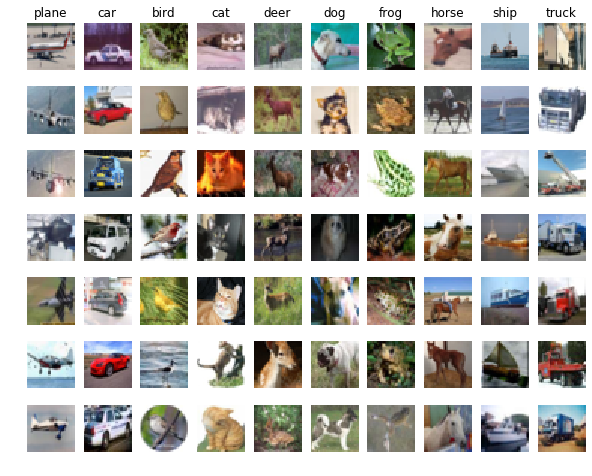

In [12]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [0]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [14]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [0]:
num_test = X_test.shape[0]
Ypred = np.zeros(num_test, dtype="int64")

In [0]:
# KNN algorithm with flexibility in number of neighbor
def get_manhattan_distance(X_point, k):
  man_distance = np.sum(np.abs(X_train - X_point), axis=1)
  return np.argsort(man_distance)[0:k]

def get_eculidean_distance(X_point, k):
  euc_distance = np.sqrt(np.sum((X_train - X_point)**2, axis=1))
  return np.argsort(euc_distance)[0:k]

In [0]:
from collections import Counter
def predict(prediction_points,k):
    num_test = prediction_points.shape[0]
    y_pred = np.zeros(num_test, dtype="int64")
    
    for i in range(num_test):
        distances=get_eculidean_distance(prediction_points[i],k)
        
        results=[]
        for index in distances:
            results.append(y_train[index])
        
        label=Counter(results).most_common(1)
        y_pred[i] = label[0][0]
        
    return np.array(y_pred)

In [18]:
# Predict labels of X_test with 1 nearest neighbor
num_correct = np.sum(predict(X_test, 1) == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [19]:
# Predict labels of X_test with 5 nearest neighbor
num_correct = np.sum(predict(X_test, 5) == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 145 / 500 correct => accuracy: 0.290000
